# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from sklearn.model_selection import train_test_split

from lightning import Trainer

from src.util.torch_device import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.lenet import FullyConvolutionalLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_numbers_distribution,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator

2. Prepare env

In [ ]:
learning_rate = 1e-3
num_epochs = 12

In [ ]:
batch_size = 32
patch_size = 9
exampes_per_class = []
target_dim = 75

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.NOPE

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

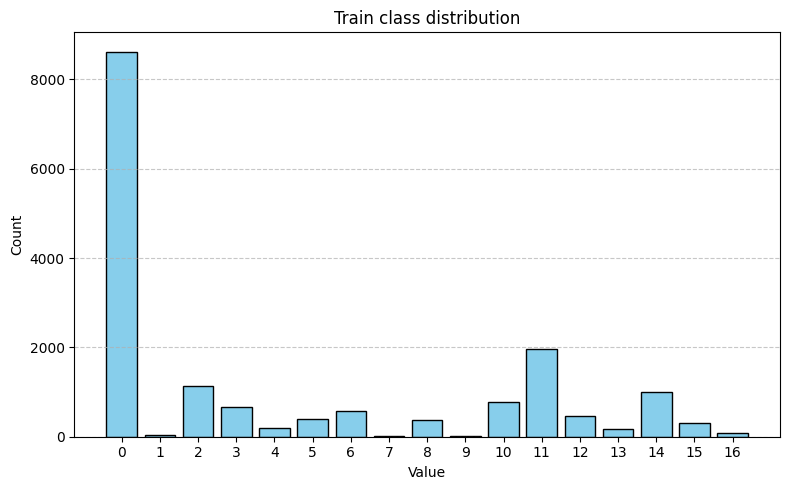

In [12]:
if exampes_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, exampes_per_class
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w), y_masked.reshape(image_h, image_w)
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

plot_numbers_distribution(y_train, desc="Train class distribution")

In [13]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [14]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [15]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [16]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 16820, Testing samples: 4205'

In [17]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

4. Train model

In [18]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(target_dim, num_classes), num_classes, lr=learning_rate
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [19]:
trainer.fit(model, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | net              | FullyConvolutionalLeNet | 509 K  | train
1 | f1               | MulticlassF1Score       | 0      | train
2 | overall_accuracy | MulticlassAccuracy      | 0      | train
3 | average_accuracy | MulticlassAccuracy      | 0      | train
4 | kappa            | MulticlassCohenKappa    | 0      | train
---------------------------------------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.040     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [20]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy       0.727942943572998
         val_f1             0.7366534471511841
        val_kappa            0.627359926700592
        val_loss             2.380244731903076
  val_overall_accuracy      0.5841554999351501
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.380244731903076,
  'val_f1': 0.7366534471511841,
  'val_overall_accuracy': 0.5841554999351501,
  'val_average_accuracy': 0.727942943572998,
  'val_kappa': 0.627359926700592}]

5. Display prediction

In [21]:
y_pred = trainer.predict(model, predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [22]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

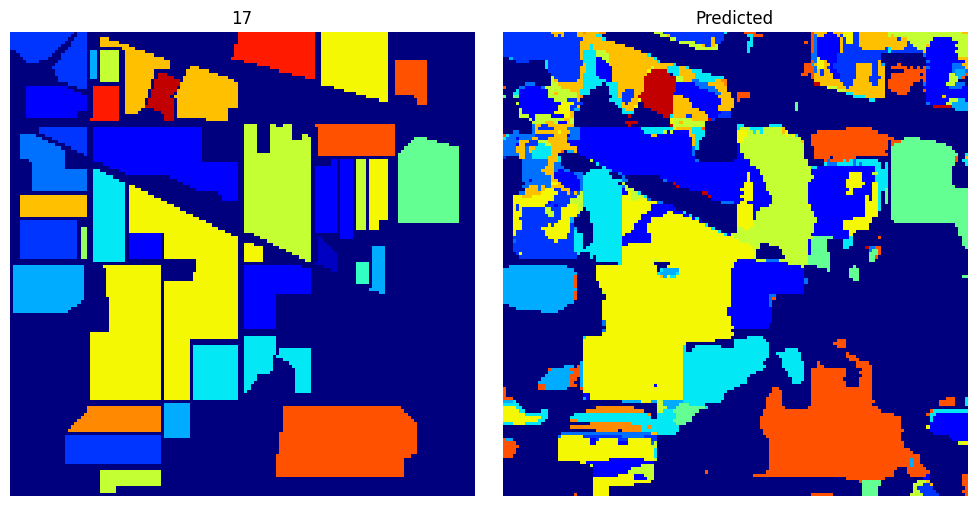

: 

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)